### Initial setup

In [141]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

#tuning
from sklearn.model_selection import RandomizedSearchCV

import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt

#### Scoring functions

In [15]:
##scoring functions
from sklearn.metrics import r2_score
EPSILON = 1e-10
def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted
def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)
def mse(actual: np.ndarray, predicted: np.ndarray):
    """Mean Squared Error"""
    return np.mean(np.square(_error(actual, predicted)))
def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))
def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))
def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return np.mean(np.abs(_error(actual, predicted)))
METRICS = {
    "mae": mae,
    "rmse": rmse,
    "mape": mape,
    "r2": r2_score,
}
def evaluate(actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "rmse", "mape", "r2")):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results

#### Read & clean data

In [142]:
df = pd.read_excel("~/Downloads/calls.xlsx",sheet_name='Sheet 1')
df.drop(['INDEX()'],axis=1,inplace=True)
df['Call Date'] = pd.to_datetime(df['Call Date'], format="%d.%m.%Y")
df['Week of Call Date'] = df['Week of Call Date'].str.replace('Week ','').astype(int)

df = df[['Call Date','Month','Year of Call Date','Week of Call Date','Day of Call Date','Weekday of Call Date','Total Incoming Calls']]



dr = pd.date_range(start='2015-01-01', end='2024-01-01')
cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

df['Holiday'] = df['Call Date'].isin(holidays)
df

#df['Quarter'] = df['Call Date'].dt.quarter
#df['Day of year'] = df['Call Date'].dt.dayofyear

#df = df.groupby(['Call Date','Year of Call Date','Month','Week of Call Date','Day of Call Date','Weekday of Call Date']).sum('Total Incoming Calls')
#df.reset_index(inplace=True)
#df

,Call Date,Month,Year of Call Date,Week of Call Date,Day of Call Date,Weekday of Call Date,Total Incoming Calls,Holiday
0,2020-01-17,1,2020,3,17,6,296,False
1,2020-01-20,1,2020,4,20,2,381,True
2,2020-01-21,1,2020,4,21,3,363,False
3,2020-01-22,1,2020,4,22,4,305,False
4,2020-01-23,1,2020,4,23,5,304,False
...,...,...,...,...,...,...,...,...
482,2021-12-09,12,2021,50,9,5,882,False
483,2021-12-10,12,2021,50,10,6,792,False
484,2021-12-13,12,2021,51,13,2,941,False
485,2021-12-14,12,2021,51,14,3,948,False


In [143]:
df.dtypes

Call Date               datetime64[ns]
Month                            int64
Year of Call Date                int64
Week of Call Date                int64
Day of Call Date                 int64
Weekday of Call Date             int64
Total Incoming Calls             int64
Holiday                           bool
dtype: object

In [144]:
#Breaking the data and selecting features , predictors
predictors=df.drop(['Total Incoming Calls','Call Date'],axis=1)
target=df['Total Incoming Calls']
x_train,x_cv,y_train,y_cv=train_test_split(predictors,target,test_size=0.2,random_state=42)

#Comparing Algorithms
def scores(i):
    lin = i()
    lin.fit(x_train, y_train)
    y_pred=lin.predict(x_cv)
    lin_r= r2_score(y_cv, y_pred)
    s.append(lin_r)
#Checking the scores by using our function
algos=[LinearRegression,KNeighborsRegressor,
       RandomForestRegressor,Lasso,ElasticNet,DecisionTreeRegressor]
s=[]
for i in algos:
    scores(i)

models = pd.DataFrame({
    'Method': ['LinearRegression', 'KNeighborsRegressor',
               'RandomForestRegressor', 'Lasso','DecisionTreeRegressor'],
    'Score': [s[0],s[1],s[2],s[3],s[4]]})
models.sort_values(by='Score', ascending=False)

,Method,Score
2,RandomForestRegressor,0.837424
1,KNeighborsRegressor,0.728075
0,LinearRegression,0.540021
3,Lasso,0.453211
4,DecisionTreeRegressor,0.435375


### RandomForest

In [146]:
resultsDict = {}
predictionsDict = {}

#model = RandomForestRegressor(min_samples_leaf=1, min_samples_split=2, n_estimators=100)
model = RandomForestRegressor()
model.fit(x_train,y_train)
y_pred = model.predict(x_cv)
#r2_score(y_cv,y_pred)

resultsDict['RandomForest'] = evaluate(y_cv, y_pred)
predictionsDict['RandomForest'] = y_pred
resultsDict['RandomForest']

{'mae': 69.47897959183673,
 'rmse': 104.05793625648734,
 'mape': 0.14792941039086427,
 'r2': 0.8450885747130115}

### XGBoost

In [151]:
#reg = xgb.XGBRegressor(objective='reg:squarederror', max_depth=6, colsample_bylevel=0.5, learning_rate=0.01, random_state=20, n_estimators=1000)
reg = xgb.XGBRegressor(objective='reg:squarederror',subsample=0.5, n_estimators=1000, max_depth=5, learning_rate=0.01, colsample_bytree=0.8, colsample_bylevel=0.8)

reg.fit(x_train, y_train,
        verbose=False, early_stopping_rounds=15,eval_set=[(x_cv,y_cv)])  # Change verbose to True if you want to see it train
y_pred = reg.predict(x_cv)
resultsDict['XGBoost'] = evaluate(y_cv, y_pred)
predictionsDict['XGBoost'] = y_pred
resultsDict['XGBoost']
#reg.feature_importances_

{'mae': 72.83096998565051,
 'rmse': 105.25071590496313,
 'mape': 0.1521933103632873,
 'r2': 0.8415168298037337}

#### XGBoost Tuner
Use computed values from below in above regressor

In [22]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
clf.fit(x_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


KeyboardInterrupt: 

### LightGBM

In [152]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(x_train, y_train)
y_pred = lightGBM.predict(x_cv)

resultsDict['Lightgbm'] = evaluate(y_cv, y_pred)
predictionsDict['Lightgbm'] = y_pred

#r2_score(y_cv, y_pred)
resultsDict['Lightgbm']

{'mae': 85.59485078951491,
 'rmse': 121.57430276717626,
 'mape': 0.180563846590471,
 'r2': 0.7885456577019125}

### NeuralProphet

In [153]:
from neuralprophet import NeuralProphet
ts = df[['Call Date','Total Incoming Calls']]
ts.columns = ['ds', 'y'] 

m = NeuralProphet(
    growth='linear',
    seasonality_mode='additive',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
).add_country_holidays(country_name='US')

df_train, df_test = m.split_df(df=ts, freq="D", valid_p=0.2)
metrics_train = m.fit(df_train, freq="D")
metrics_test = m.test(df=df_test)

metrics_test

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.331% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.179% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 271


  0%|          | 0/117 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.61E-01, min: 3.29E-01


  0%|          | 0/117 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.61E-01, min: 3.93E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.37E-01
Epoch[271/271]: 100%|█| 271/271 [00:04<00:00, 63.98it/s, SmoothL1Loss=0.00556, M
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.907% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.027 177.995 233.848


,SmoothL1Loss,MAE,RMSE
0,0.026964,177.995209,233.8479


In [154]:
forecast

,ds,y,yhat1,residual1,trend,season_weekly,ts_np
0,2020-01-17,296,240.962784,-55.037216,-65.105156,306.067932,244.653656
1,2020-01-20,381,336.942902,-44.057098,-68.344604,405.287506,338.533478
2,2020-01-21,363,362.602936,-0.397064,-69.424416,432.027374,364.341644
3,2020-01-22,305,342.218201,37.218201,-70.504227,412.722443,347.549957
4,2020-01-23,304,307.004761,3.004761,-71.584038,378.588806,310.214752
...,...,...,...,...,...,...,...
482,2021-12-09,882,956.412842,74.412842,577.824036,378.588806,958.672241
483,2021-12-10,792,887.842712,95.842712,581.774780,306.067932,889.802490
484,2021-12-13,941,998.914368,57.914368,593.626831,405.287506,999.214966
485,2021-12-14,948,1029.604614,81.604614,597.577271,432.027374,1030.200439


### Compare regression models

In [155]:
models = ['RandomForest',
          'Lightgbm',
          'XGBoost']
resis = pd.DataFrame(data={k: y_cv -
                              v for k, v in predictionsDict.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient(cmap='coolwarm')

Residuals correlation


,RandomForest,Lightgbm,XGBoost
RandomForest,1.000000,0.819476,0.889762
Lightgbm,0.819476,1.000000,0.906895
XGBoost,0.889762,0.906895,1.000000


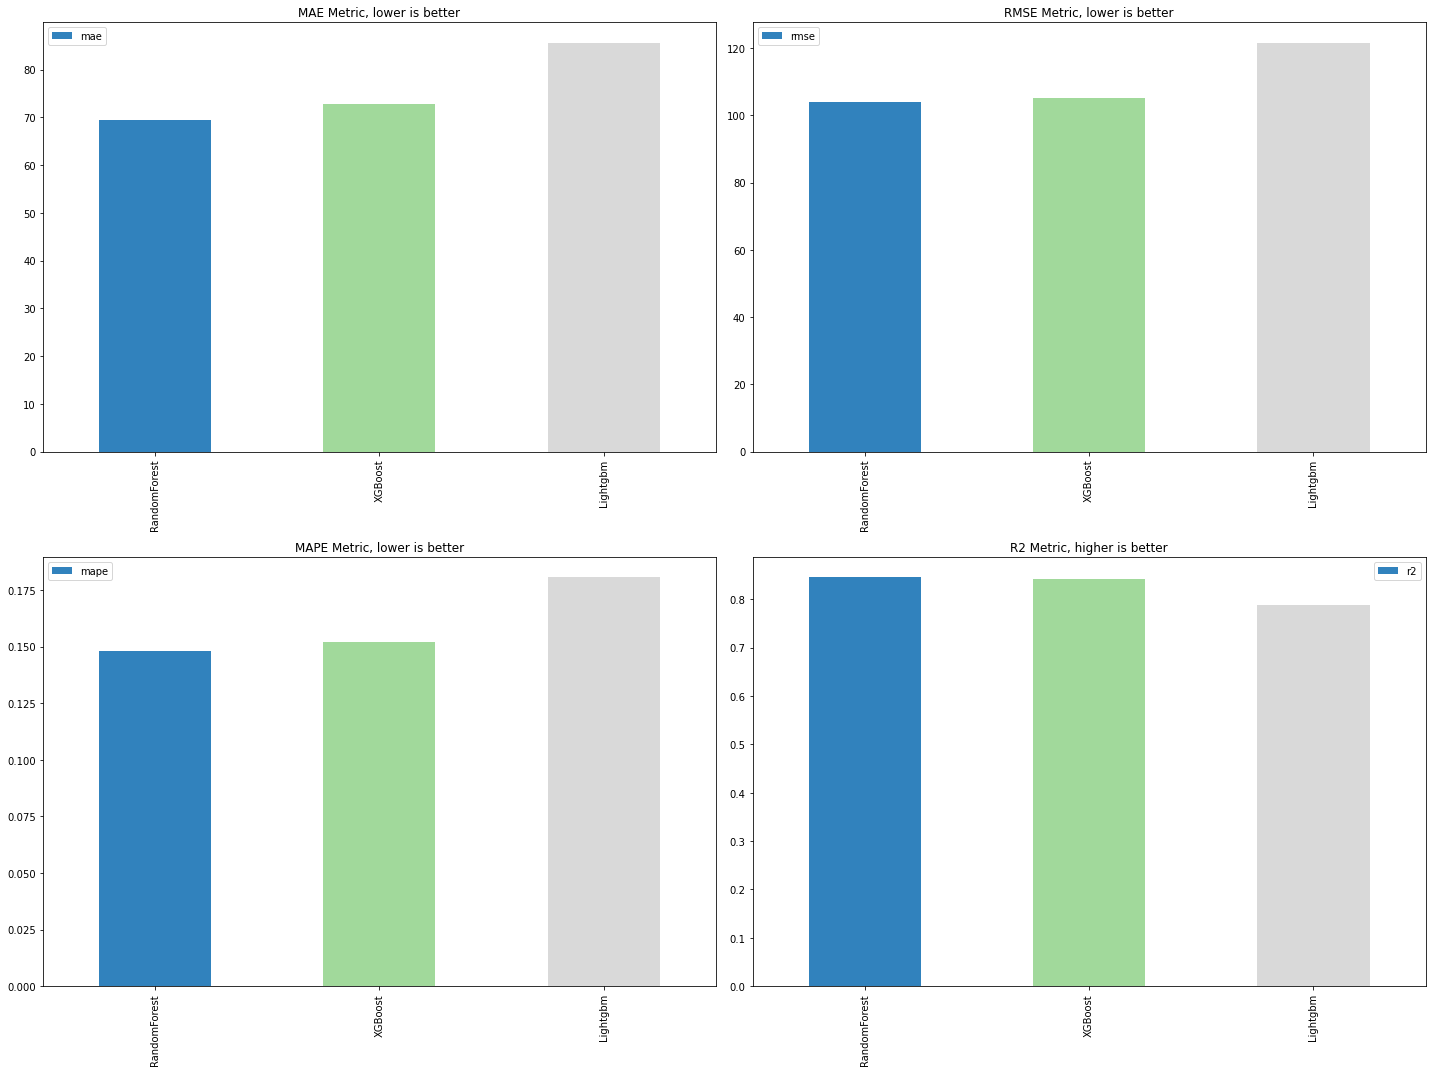

In [157]:
def bar_metrics(resultsDict):
    df = pd.DataFrame.from_dict(resultsDict)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    pallette = plt.cm.get_cmap("tab20c", len(df.columns))
    colors = [pallette(x) for x in range(len(df.columns))]
    color_dict = dict(zip(df.columns, colors))
    fig = plt.figure(figsize=(20, 15))

    # MAE plot
    fig.add_subplot(2, 2, 1)
    df.loc["mae"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[color_dict.get(x, "#333333") for x in df.loc["mae"].sort_values().index],
    )
    plt.legend()
    plt.title("MAE Metric, lower is better")
    fig.add_subplot(2, 2, 2)
    df.loc["rmse"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["rmse"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("RMSE Metric, lower is better")
    fig.add_subplot(2, 2, 3)
    df.loc["mape"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["mape"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("MAPE Metric, lower is better")
    fig.add_subplot(2, 2, 4)
    df.loc["r2"].sort_values(ascending=False).plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333")
            for x in df.loc["r2"].sort_values(ascending=False).index
        ],
    )
    plt.legend()
    plt.title("R2 Metric, higher is better")
    plt.tight_layout()
    plt.show()
bar_metrics(resultsDict)

### Fit models and export data

In [156]:
#RandomForest
reg_rf = RandomForestRegressor()
reg_rf.fit(predictors, target)

#XGBoost
reg_xgb = xgb.XGBRegressor(objective='reg:squarederror',subsample=0.5, n_estimators=1000, max_depth=5, learning_rate=0.01, colsample_bytree=0.8, colsample_bylevel=0.8)
reg_xgb.fit(predictors, target)

#LightGBM
reg_lgb = lgb.LGBMRegressor()
reg_lgb.fit(predictors, target)

#NeuralProphet
ts_np = NeuralProphet(
    growth='linear',
    seasonality_mode='additive',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True
).add_country_holidays(country_name='US')

ts_np.fit(ts, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.331% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 248


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.26E-01, min: 5.15E-01


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E-01, min: 3.04E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.10E-01
Epoch[248/248]: 100%|█| 248/248 [00:04<00:00, 53.32it/s, SmoothL1Loss=0.00729, M


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.658262,1062.557707,1282.603791,0.0
1,0.607542,1006.792362,1213.441415,0.0
2,0.554304,947.113369,1138.150915,0.0
3,0.497617,883.041772,1062.123633,0.0
4,0.429811,804.759482,972.250519,0.0
...,...,...,...,...
243,0.007311,87.842422,117.164944,0.0
244,0.007310,87.891801,116.055942,0.0
245,0.007298,87.809815,116.908572,0.0
246,0.007293,87.750745,117.255428,0.0


In [162]:
future = pd.read_excel('~/Downloads/calls_test.xlsx')
future['Call Date'] = pd.to_datetime(future['Call Date'], format="%d.%m.%Y")
future['Holiday'] = future['Call Date'].isin(holidays)
prediction = future.drop(['Call Date'],axis=1)

future['rf'] = reg_rf.predict(prediction)
future['xgb'] = reg_xgb.predict(prediction)
future['lgb'] = reg_lgb.predict(prediction)
future['lgb'] = reg_lgb.predict(prediction)
future['ts_np'] = ts_np.predict(ts).yhat1

export = pd.concat([df, future])

with pd.ExcelWriter("~/Downloads/calls.xlsx", engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    export.to_excel(writer, 'Future', index=False)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.331% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.331% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [161]:
export

,Call Date,Month,Year of Call Date,Week of Call Date,Day of Call Date,Weekday of Call Date,Total Incoming Calls,Holiday,rf,xgb,lgb,ts_np
0,2020-01-17,1,2020,3,17,6,296.0,False,NaN,NaN,NaN,NaN
1,2020-01-20,1,2020,4,20,2,381.0,True,NaN,NaN,NaN,NaN
2,2020-01-21,1,2020,4,21,3,363.0,False,NaN,NaN,NaN,NaN
3,2020-01-22,1,2020,4,22,4,305.0,False,NaN,NaN,NaN,NaN
4,2020-01-23,1,2020,4,23,5,304.0,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
43,2022-01-27,12,2022,5,27,5,NaN,False,331.98,593.130371,199.617472,302.899963
44,2022-01-28,12,2022,5,28,6,NaN,False,308.69,540.799927,187.340233,222.292953
45,2022-01-29,12,2022,5,29,7,NaN,False,302.67,535.403992,187.340233,322.890991
46,2022-01-30,12,2022,5,30,1,NaN,False,328.07,634.370850,229.992146,336.703369
